In [51]:
from sklearn.datasets import load_svmlight_file
from sklearn.cross_validation import train_test_split
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
import timeit

In [52]:
#参数设置
train_file = "C:/Users/Administrator/Desktop/deep learning experients/a9a.svm"
valid_file = "C:/Users/Administrator/Desktop/deep learning experients/a9a.t"
reg = 1
#最大迭代次数
num_iter = 200  
#每次训练的batch
k = 100  
eta = 0.01
gamma = 0.9
eps = 1e-8
beta=0.9

In [53]:
def classify(label):
    if label == 1: return 1
    else: return 0

In [54]:
#训练及优化
def NAG_stocGradAscent(dataMatrix, classLabels, X1, y1, weights):

    new_weights = weights
    m, n = shape(dataMatrix)
    Loss_valid = []
    monu = mat(np.zeros((n,2))) 
    # NAG,初始化是否为零？
    for j in range(num_iter):
        loss_valid = compute_loss(new_weights, X1, y1)
        Loss_valid.append(float(loss_valid))
        if j % 10 == 0:
            print('iter {0}: valid_loss={1}'.format(j, float(loss_valid)))
        new_weights = NAG_compute_gradient(new_weights, dataMatrix, classLabels, monu)

    return [new_weights, Loss_valid]

In [55]:
#训练及优化
def RMSProp_stocGradAscent(dataMatrix, classLabels, X1, y1, weights):

    new_weights = weights
    m, n = shape(dataMatrix)
    Loss_valid = []
    g = mat(np.zeros((n, 2))) 
    # 初始化是否为零？
    for j in range(num_iter):
        loss_valid = compute_loss(new_weights, X1, y1)
        Loss_valid.append(float(loss_valid))
        if j % 10 == 0:
            print('iter {0}: valid_loss={1}'.format(j, float(loss_valid)))
        new_weights = RMSProp_compute_gradient(new_weights, dataMatrix, classLabels, g)

    return [new_weights, Loss_valid]

In [56]:
#训练及优化
def AdaDelta_stocGradAscent(dataMatrix, classLabels, X1, y1, weights):

    new_weights = weights
    m, n = shape(dataMatrix)
    Loss_valid = []
    g = mat(np.zeros((n, 2))) # 初始化是否为零？
    delta = mat(np.zeros((n, 2)))  # delta
    for j in range(num_iter):
        loss_valid = compute_loss(new_weights, X1, y1)
        Loss_valid.append(float(loss_valid))
        if j % 10 == 0:
            print('iter {0}: valid_loss={1}'.format(j, float(loss_valid)))
        new_weights = AdaDelta_compute_gradient(new_weights, dataMatrix, classLabels, g,delta)

    return [new_weights, Loss_valid]

In [57]:
#训练及优化
def Adam_stocGradAscent(dataMatrix, classLabels, X1, y1, weights):

    new_weights = weights
    m, n = shape(dataMatrix)
    Loss_valid = []
    g = mat(np.zeros((n, 2))) # 初始化是否为零？
    moments = mat(np.zeros((n, 2)))  # delta
    for j in range(num_iter):
        loss_valid = compute_loss(new_weights, X1, y1)
        Loss_valid.append(float(loss_valid))
        if j % 10 == 0:
            print('iter {0}: valid_loss={1}'.format(j, float(loss_valid)))
        new_weights = Adam_compute_gradient(new_weights, dataMatrix, classLabels, g, moments,j)

    return [new_weights, Loss_valid]

In [58]:
#梯度更新
def NAG_compute_gradient(w_current,data,label,monu):
    #start_time = timeit.default_timer()
    m, n = shape(data)
    dataIndex = list(range(m))
    new_weights = w_current
    w_gradient = np.zeros((n, 2))  # n*2
    for i in range(k):
        temp_weights = new_weights - gamma * monu
        randIndex = int(random.uniform(0, len(dataIndex)))
        v = data[randIndex, :]  #1*n
        score=predict(temp_weights, v) #1*2
        correct_score=classify(label[randIndex])
        for j in range(2):
            if j==correct_score:   #classify(label[i])=correct_score
                continue
            margin = score[0, j]-correct_score+1
            if margin > 0:
                w_gradient[:,correct_score] = w_gradient[:,correct_score] - v
                w_gradient[:,j] = w_gradient[:,j] + v
        del (dataIndex[randIndex])
    w_gradient /= k
    w_gradient += 2*reg*new_weights
    monu = gamma * monu + eta * w_gradient
    new_weights = new_weights - monu

    # end_time = timeit.default_timer()
    # print(end_time - start_time)
    return new_weights

In [59]:
def RMSProp_compute_gradient(w_current,data,label,g):

    #start_time = timeit.default_timer()
    m, n = shape(data)
    dataIndex = list(range(m))
    new_weights = w_current
    epsilon = np.ones((n,2)) * eps
    w_gradient = np.zeros((n, 2))  # n*2
    for i in range(k):
        randIndex = int(random.uniform(0, len(dataIndex)))
        v = data[randIndex, :]  #1*n
        score=predict(new_weights, v) #1*2
        correct_score=classify(label[randIndex])
        for j in range(2):
            if j==correct_score:   #classify(label[i])=correct_score
                continue
            margin = score[0, j]-correct_score+1
            if margin > 0:
                w_gradient[:,correct_score] = w_gradient[:,correct_score] - v
                w_gradient[:,j] = w_gradient[:,j] + v
        del (dataIndex[randIndex])
    w_gradient /= k
    w_gradient += 2*reg*new_weights
    g = gamma * g + (1 - gamma) * square(w_gradient)    #矩阵加数组平方？点操作
    new_weights = new_weights - eta * w_gradient / sqrt(g + epsilon)    #点操作？

    # end_time = timeit.default_timer()
    # print(end_time - start_time)
    return new_weights

In [60]:
#梯度更新
def AdaDelta_compute_gradient(w_current,data,label,g,delta):

    m, n = shape(data)
    dataIndex = list(range(m))
    new_weights = w_current
    epsilon = np.ones((n,2)) * eps
    w_gradient = np.zeros((n, 2))  # n*2
    for i in range(k):
        randIndex = int(random.uniform(0, len(dataIndex)))
        v = data[randIndex, :]  #1*n
        score=predict(new_weights, v) #1*2
        correct_score=classify(label[randIndex])
        for j in range(2):
            if j==correct_score:   #classify(label[i])=correct_score
                continue
            margin = score[0, j]-correct_score+1
            if margin > 0:
                w_gradient[:,correct_score] = w_gradient[:,correct_score] - v
                w_gradient[:,j] = w_gradient[:,j] + v
        del (dataIndex[randIndex])
    w_gradient /= k
    w_gradient += 2*reg*new_weights
    g = gamma * g + (1 - gamma) * square(w_gradient)    #矩阵加数组平方？点操作
    dx = sqrt(delta + epsilon) / sqrt(g + epsilon)
    new_weights = new_weights - dx.A * w_gradient
    delta = gamma * delta + (1-gamma) * square(dx.A * w_gradient)

    return new_weights

In [61]:
#梯度更新
def Adam_compute_gradient(w_current,data,label,g,moments,j):

    m, n = shape(data)
    dataIndex = list(range(m))
    new_weights = w_current
    epsilon = np.ones((n,2)) * eps
    w_gradient = np.zeros((n, 2))  # n*2
    for i in range(k):
        randIndex = int(random.uniform(0, len(dataIndex)))
        v = data[randIndex, :]  #1*n
        score=predict(new_weights, v) #1*2
        correct_score=classify(label[randIndex])
        for j in range(2):
            if j==correct_score:   #classify(label[i])=correct_score
                continue
            margin = score[0, j]-correct_score+1
            if margin > 0:
                w_gradient[:,correct_score] = w_gradient[:,correct_score] - v
                w_gradient[:,j] = w_gradient[:,j] + v
        del (dataIndex[randIndex])
    w_gradient /= k
    w_gradient += 2*reg*new_weights
    g = gamma * g + (1 - gamma) * square(w_gradient)    #矩阵加数组平方？点操作
    moments = beta * moments + (1 - beta) * w_gradient
    alpha = eta * sqrt(1 - gamma ** (j + 1)) / (1 - beta ** (j + 1))
    new_weights = new_weights - alpha * moments / sqrt(g + epsilon)

    return new_weights

In [62]:
def predict(w,v):
    return v*w  #1*M * M*2 = 1*2

In [63]:
#计算Loss函数值
def compute_loss(w, data, label):
    #start_time = timeit.default_timer()
    N, M = shape(data)
    loss=0.0
    for i in range(N):
        v = data[i, :]  #1*M
        score=predict(w, v) #1*2
        correct_score = classify(label[i])
        for j in range(2):
            if j==correct_score:
                continue
            margin = score[0, j]-correct_score+1
            if margin>0:
                loss+=margin
    loss/=N
    # end_time = timeit.default_timer()
    # print(end_time - start_time)
    return loss

In [64]:
#读入数据
def get_data(filename):

    data = load_svmlight_file(filename)
    X=data[0].toarray()
    y=data[1]
    count = X.shape[0]
    if filename=="C:/Users/Administrator/Desktop/deep learning experients/a9a.t":
        X = np.column_stack((X, np.zeros((count, 1))))
    np.c_[X, np.ones(count)]
    return [X, y]

In [65]:
def plot_loss(y2):

    #plt.plot(y1, label='train_loss')
    plt.plot(y2, label='valid_loss')
    plt.legend()
    plt.xlabel('iteration');
    plt.ylabel('Loss');
    plt.show()

In [66]:
def NAG_linear_classification():

    # 参数初始化
    loss_valid = []
    X,y = get_data(train_file)
    X1,y1 = get_data(valid_file)
    m, n = shape(X)
    m1, n1 = shape(X1)
    weights = mat(np.zeros((n,2)))
    weights, loss_valid = NAG_stocGradAscent(X, y, X1, y1, weights)
    plot_loss(loss_valid)

In [67]:
def RMSProp_linear_classification():

    # 参数初始化
    loss_valid = []
    X,y = get_data(train_file)
    X1,y1 = get_data(valid_file)
    m, n = shape(X)
    m1, n1 = shape(X1)
    weights = mat(np.zeros((n,2)))
    weights, loss_valid = RMSProp_stocGradAscent(X, y, X1, y1, weights)
    plot_loss(loss_valid)

In [68]:
def AdaDelta_linear_classification():

    # 参数初始化
    loss_valid = []
    X,y = get_data(train_file)
    X1,y1 = get_data(valid_file)
    m, n = shape(X)
    m1, n1 = shape(X1)
    weights = mat(np.zeros((n,2)))
    weights, loss_valid = AdaDelta_stocGradAscent(X, y, X1, y1, weights)
    plot_loss(loss_valid)

In [69]:
def Adam_linear_classification():

    # 参数初始化
    loss_valid = []
    X,y = get_data(train_file)
    X1,y1 = get_data(valid_file)
    m, n = shape(X)
    m1, n1 = shape(X1)
    weights = mat(np.zeros((n,2)))
    weights, loss_valid = Adam_stocGradAscent(X, y, X1, y1, weights)
    plot_loss(loss_valid)

L_NAG
iter 0: valid_loss=0.7637737239727289
iter 10: valid_loss=0.5791030080935679
iter 20: valid_loss=0.4462307065014906
iter 30: valid_loss=0.35994204492743426
iter 40: valid_loss=0.28133606983015047
iter 50: valid_loss=0.26207121059992633
iter 60: valid_loss=0.2630347382426421
iter 70: valid_loss=0.25706500150028605
iter 80: valid_loss=0.2617746622210423
iter 90: valid_loss=0.2605518097146596
iter 100: valid_loss=0.25761949571470877
iter 110: valid_loss=0.26245108528440503
iter 120: valid_loss=0.25816619404063046
iter 130: valid_loss=0.25744425498274476
iter 140: valid_loss=0.256033507303471
iter 150: valid_loss=0.2568121450577297
iter 160: valid_loss=0.25371333897416437
iter 170: valid_loss=0.2543178908601462
iter 180: valid_loss=0.2579516018803413
iter 190: valid_loss=0.25801858020089097


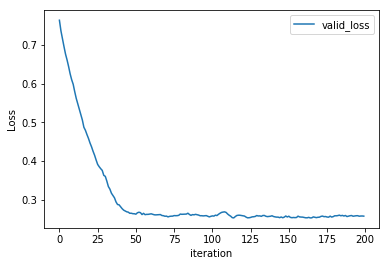

L_RMSProp
iter 0: valid_loss=0.7637737239727289
iter 10: valid_loss=0.3991956358807924
iter 20: valid_loss=0.3707731246535399
iter 30: valid_loss=0.37943371616895155
iter 40: valid_loss=0.38728223214714086
iter 50: valid_loss=0.37238292940634743
iter 60: valid_loss=0.3930667152390012
iter 70: valid_loss=0.3482044041696296
iter 80: valid_loss=0.389394889774584
iter 90: valid_loss=0.35901522871387814
iter 100: valid_loss=0.3649494677016352
iter 110: valid_loss=0.3796813243010055
iter 120: valid_loss=0.3851629593627352
iter 130: valid_loss=0.39519086428478045
iter 140: valid_loss=0.23359796758137544
iter 150: valid_loss=0.24523572166264454
iter 160: valid_loss=0.24549766063908599
iter 170: valid_loss=0.23325475930493625
iter 180: valid_loss=0.2464207060629889
iter 190: valid_loss=0.2358068501412654


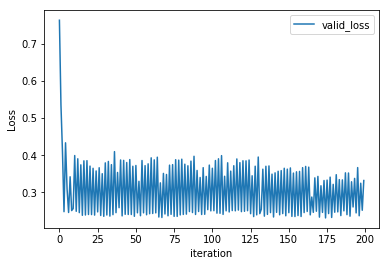

L_AdaDelta
iter 0: valid_error=0.7637737239727289
iter 10: valid_error=0.741941268920667
iter 20: valid_error=0.7200801811842926
iter 30: valid_error=0.6988103647803365
iter 40: valid_error=0.678186668922422
iter 50: valid_error=0.6576793991582343
iter 60: valid_error=0.6372744808495122
iter 70: valid_error=0.6172155448723597
iter 80: valid_error=0.5968510702745204
iter 90: valid_error=0.5776495201008289
iter 100: valid_error=0.5591479811414768
iter 110: valid_error=0.5410056833930534
iter 120: valid_error=0.522288508439602
iter 130: valid_error=0.5041440287112297
iter 140: valid_error=0.48633139296544914
iter 150: valid_error=0.46904586693417516
iter 160: valid_error=0.45148114057033956
iter 170: valid_error=0.4340614552896812
iter 180: valid_error=0.4173765597609939
iter 190: valid_error=0.401016498853686


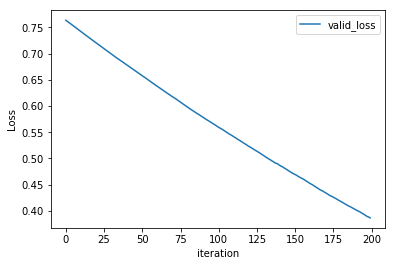

L_Adam
iter 0: valid_error=0.7637737239727289
iter 10: valid_error=0.3329579053521411
iter 20: valid_error=0.2547038424264827
iter 30: valid_error=0.2762742763546322
iter 40: valid_error=0.2748746035963084
iter 50: valid_error=0.24142056634400635
iter 60: valid_error=0.24460512575050783
iter 70: valid_error=0.26227226022620836
iter 80: valid_error=0.2599158730729486
iter 90: valid_error=0.270264818483559
iter 100: valid_error=0.24759744884731966
iter 110: valid_error=0.27011648088748286
iter 120: valid_error=0.24555920418350752
iter 130: valid_error=0.24245647637719125
iter 140: valid_error=0.2511031626987859
iter 150: valid_error=0.27714073640724785
iter 160: valid_error=0.2885556531584563
iter 170: valid_error=0.273933173696507
iter 180: valid_error=0.24440789113009917
iter 190: valid_error=0.2792558968949294


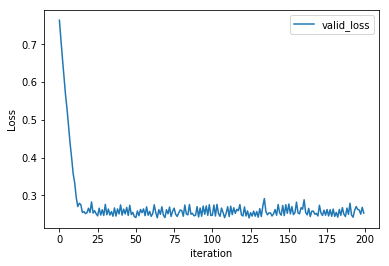

In [70]:
if __name__ =='__main__':
    print("L_NAG")
    NAG_linear_classification()
    print("L_RMSProp")
    RMSProp_linear_classification()
    print("L_AdaDelta")
    AdaDelta_linear_classification()
    print("L_Adam")
    Adam_linear_classification()